In [1]:
# 利用するライブラリのインポート及び、関数の作成

import matplotlib
#matplotlib.use('Qt5Agg')  # インタラクティブなバックエンドに設定
red_bird   = [ 0.2082, 0.0592, 0.0780, 0.0232, 0.1802, 0.5301, 0.8186, 0.9956, 0.9764]
green_bird = [ 0.1664, 0.3599, 0.5041, 0.6419, 0.7178, 0.7492, 0.7328, 0.7862, 0.9832]
blue_bird  = [ 0.5293, 0.8684, 0.8385, 0.7914, 0.6425, 0.4662, 0.3499, 0.1968, 0.0539]
cdict_bird = dict([(key,tuple([(i/8,val,val) for i,val in enumerate(eval(key+"_bird"))])) for key in ["red","green","blue"]])
cmap_bird = matplotlib.colors.LinearSegmentedColormap('bird', cdict_bird)

import os
import glob
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.colors import LogNorm

from get_cellid_within_range import get_row_col, get_cells_in_range, get_row_col_for_cells_in_range
from load_output_internet import load_output


# 指定した行番号のデータを各ファイルから取り出し、配列を作成する（特定の時間帯のデータを全ファイルから取り出す）
def create_array_from_files(files_data, num):
    row = [file_data[num] if num < len(file_data) else None for file_data in files_data]
    return np.array([row])

# time_unitに応じた時間列を取り出す
def get_timeseries(cell_id, time_unit):   
    # ベースパスを設定し、ファイルを取り出す（'hour' または 'minute' ディレクトリに基づいて）
    base_path = r"C:\Users\goshima\Documents\卒業研究_AI\Python\Datasets\Datasets_output"
    file_path = os.path.join(base_path, time_unit, f"{time_unit}-mi-ID-{cell_id}.csv")
    if os.path.exists(file_path):
        datetime = pd.read_csv(file_path, usecols=["datetime"])
    else:
        print(f"ファイルが存在しません: {file_path}")
    return datetime

# グラフの結果を保存するディレクトリを取得する
def get_save_directory(time_unit):
    base_path = r"C:\Users\goshima\Documents\卒業研究_AI\Python\Graph_result"
    dir_path = os.path.join(base_path, time_unit)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

In [2]:
# 反復処理外の処理

# 変数の指定
center_cell_id = 5161
cell_range = 30
time_unit = 'minute'
interval = 30

# labelに使用する行番号（row）と列番号（col）を取得
rows, cols = get_row_col_for_cells_in_range(center_cell_id, cell_range)

# 格子点を作成
vals = np.arange(len(rows))
X, Y = np.meshgrid(vals, vals)

# 起点を設定
x = X.flatten()
y = Y.flatten()
z = np.zeros_like(x)

# 変化量を指定（zの変化量は反復処理ごとに変わる）
a = 0.4  # バーのハーフサイズの値を指定（小さくすると棒グラフが細くなる）
dx = np.repeat(a=a * 2.0, repeats=len(x))
dy = np.repeat(a=a * 2.0, repeats=len(y))

# Z軸の上限と下限を設定
z_min = 0    # Z軸の下限
z_max = 7000 # Z軸の上限

# カラーマップを指定
cmap = cmap_bird
cm = plt.get_cmap(cmap)

# mappableの設定
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z_min, vmax=z_max))

# 使用するデータセットの読み込み（y_test_pred列のみを取り出す）
files_data = load_output(center_cell_id, cell_range, time_unit)

# 時間列を取り出し、列数を取得（ラベル名変更及び、反復処理時の列数として使用）
datetime = get_timeseries(center_cell_id, time_unit)
datetime["datetime"] = pd.to_datetime(datetime["datetime"])

# グラフの結果を保存するディレクトリを取得する
save_dir = get_save_directory(time_unit)


In [ ]:
# 反復処理でのグラフ作成と保存
for i in range(len(datetime)):
    # dzに指定するデータの取り込み、代入
    dz_value = create_array_from_files(files_data, i)
    dz_value = dz_value.flatten()
    dz = np.array(dz_value)

    # 3D棒グラフの作成
    fig = plt.figure(figsize=(33, 30))  # 図の設定
    ax = fig.add_subplot(projection='3d')  # 3D用の設定

    # 視点の設定（ここで角度を調整）
    ax.view_init(elev=30, azim=120) #（y軸の角度, x軸の角度）

    # Z軸の上限と下限を適用し、カラーを設定
    ax.set_zlim(z_min, z_max)
    color_values = cm(dz / z_max)
    edgecolor_values = cm(np.repeat(dz / z_max, 6))

    # 3D棒グラフの設定
    bar = ax.bar3d(
        x=x-a,
        y=y-a,
        z=z, 
        dx=dx, 
        dy=dy, 
        dz=dz, 
        color=color_values, 
        edgecolor=edgecolor_values, 
        alpha=0.5,
        linewidth=0.8
    )

    # ラベル設定（z軸は手動で設定）
    ax.set_xlabel('x', fontsize='40', labelpad=30)  # x軸ラベル
    ax.set_ylabel('y', fontsize='40', labelpad=30)  # y軸ラベル
    ax.text(
        x=-10.5, y=0.5, z=z_max*(4/5),  # ラベルの位置
        s="Traffic",              # ラベルのテキスト
        rotation=90,               # ラベルを回転
        ha='center', va='center',  # ラベルの配置
        fontsize=40, color='black' # ラベルのスタイル
    )
    ax.set_title(f'Milano-internet-pred ({datetime["datetime"].iloc[i].strftime("%Y-%m-%d %H:%M")})', fontsize='60')

    # 目盛りの間隔をstepにて設定する
    step = 2
    ax.set_xticks(np.arange(0, len(rows), step))
    ax.set_yticks(np.arange(0, len(cols), step))
    ax.set_xticklabels(labels=rows[::step], fontsize='32')  # 行番号を設定
    ax.set_yticklabels(labels=cols[::step], fontsize='32')  # 列番号を設定
    ax.zaxis.set_tick_params(labelsize=40) 

    # カラーバーの設定（axを指定）
    mappable.set_array(dz)
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    # カラーバーの目盛りのフォントサイズを変更
    cbar.ax.tick_params(labelsize=32)

    # ディレクトリを指定し、グラフをpng形式で保存
    save_path = os.path.join(save_dir, f"{time_unit}-mi-{datetime['datetime'].iloc[i].strftime('%Y-%m-%d_%H-%M')}.png")
    plt.savefig(save_path)

    plt.close(fig)

In [ ]:
# 作成したグラフ画像を読み込み、GIF形式でアニメーションを保存

# 初期設定
fig, ax = plt.subplots(figsize=(33, 30), constrained_layout=True)  # フィギュアサイズの指定
dir_path = get_save_directory(time_unit)  # 保存先のディレクトリ
files_path = glob.glob(f"{dir_path}/*.png")  # 画像ファイルのパス

# 画像を取得
images = []
for file_path in files_path:
    image = Image.open(file_path)  # 画像を開く
    images.append(image)  # リストに追加

# 外枠を削除
ax.margins(0)
ax.axis('off')  # 軸を非表示
ax.set_xticks([])  # x軸の目盛りを非表示
ax.set_yticks([])  # y軸の目盛りを非表示

# フレームを作成
frames = []
for img in images:
    im = ax.imshow(img, animated=True)
    frames.append([im])

# アニメーションの作成
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=False)  # blit=Falseでアニメーションをすべて表示

# GIFとして保存（dpiの値で画像の解像度を調整）
gif_path = os.path.join(r"C:\Users\goshima\Documents\卒業研究_AI\Python\Graph_result\GIF", f"{time_unit}-output.gif")
ani.save(gif_path, writer='pillow', dpi=300) 



In [ ]:
plt.show()

In [107]:
# 反復処理外の処理

# cell_range×cell_rangeの範囲を指定
center_cell_id = 5161
cell_range = 30
time_unit = 'minute'

# labelに使用する行番号（row）と列番号（col）を取得
rows, cols = get_row_col_for_cells_in_range(center_cell_id, cell_range)

# 格子点を作成
vals = np.arange(len(rows))
X, Y = np.meshgrid(vals, vals)

# 起点を設定
x = X.flatten()
y = Y.flatten()
z = np.zeros_like(x)

# 変化量を指定（zの変化量は反復処理ごとに変わる）
a = 0.4  # バーのハーフサイズの値を指定（小さくすると棒グラフが細くなる）
dx = np.repeat(a=a * 2.0, repeats=len(x))
dy = np.repeat(a=a * 2.0, repeats=len(y))

# 使用するデータセットの読み込み（y_test_pred列のみを取り出す）
files_data = load_output(center_cell_id, cell_range, time_unit)

# 時間列を取り出し、列数を取得（ラベル名変更及び、反復処理時の列数として使用）
datetime = get_timeseries(center_cell_id, time_unit)
datetime["datetime"] = pd.to_datetime(datetime["datetime"])

# グラフの結果を保存するディレクトリを取得する
save_dir = get_save_directory(time_unit)

# z軸の上限値と下限値を計算
all_data = [value for sublist in files_data for value in sublist]
z_max = max(all_data) if all_data else None
z_min = min(all_data) if all_data else None

# カラーマップを指定
cmap = cmap_bird
cm = plt.get_cmap(cmap)

# mappableの設定（対数スケール）
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=z_min, vmax=z_max))

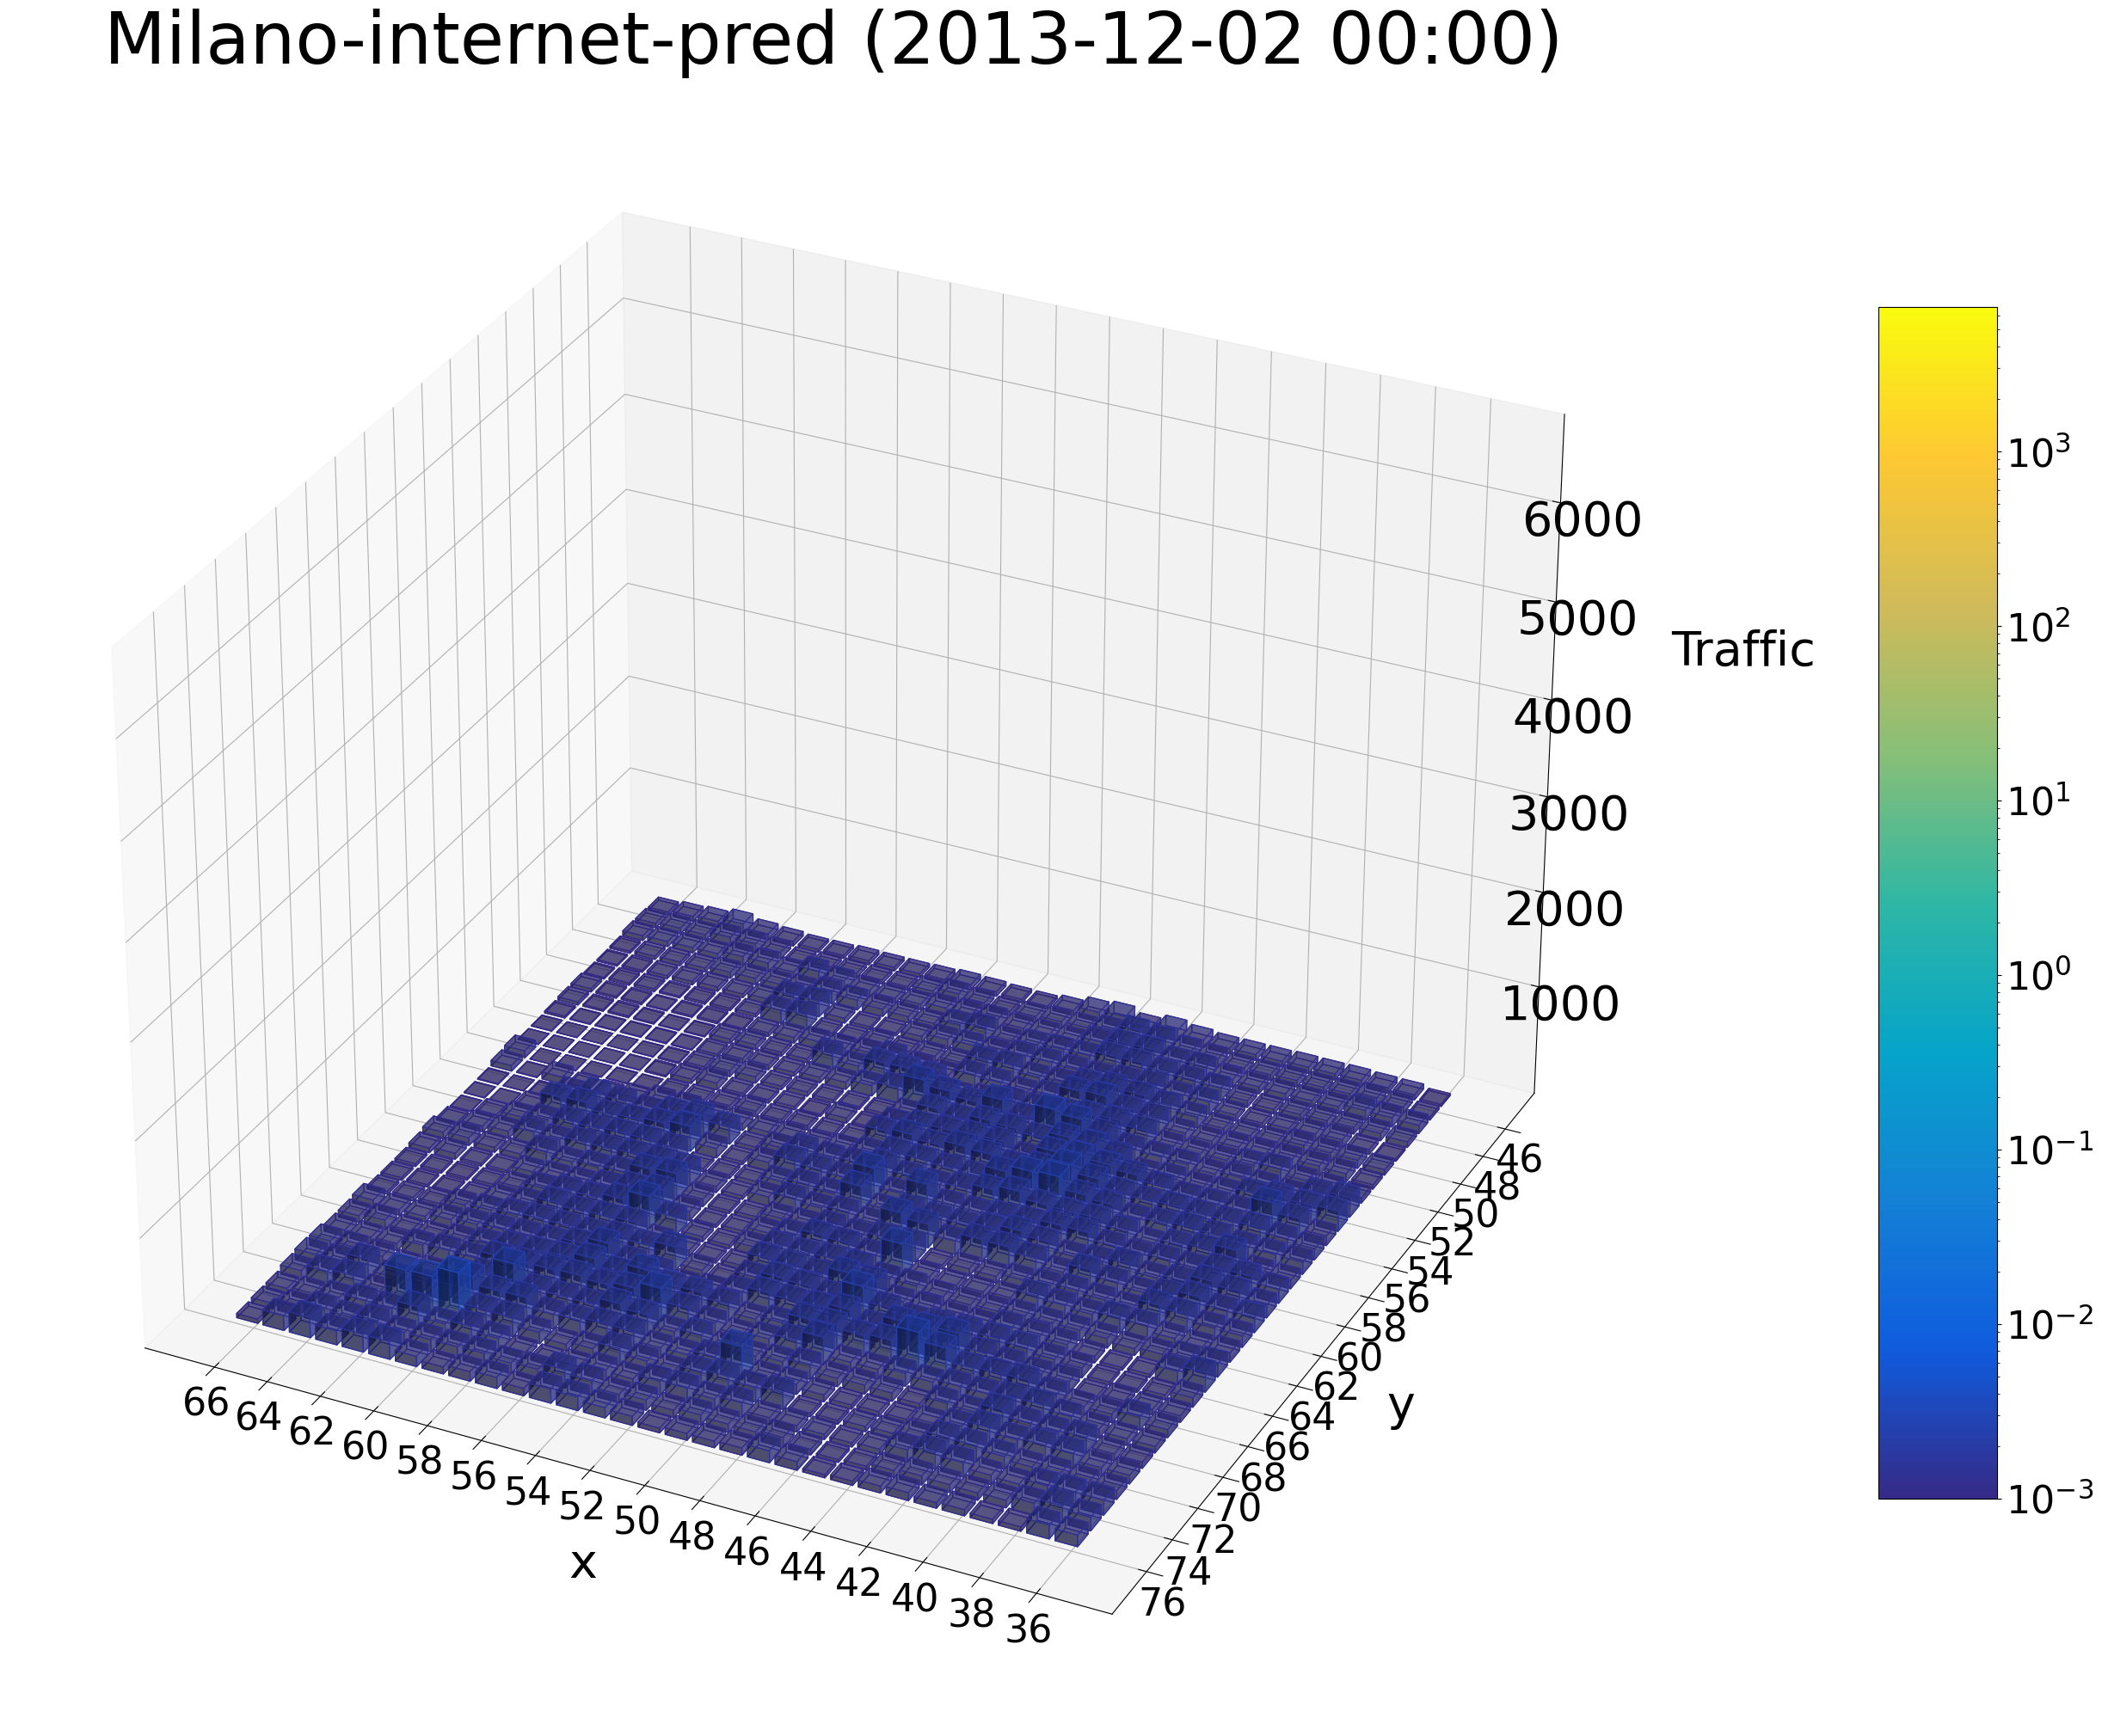

In [115]:
# 反復処理でのグラフ作成と保存
for i in range(1):
#for i in range(len(datetime)):
    # dzに指定するデータの取り込み、代入
    dz_value = create_array_from_files(files_data, i)
    dz_value = dz_value.flatten()
    dz = np.array(dz_value)

    # 3D棒グラフの作成
    fig = plt.figure(figsize=(33, 30))  # 図の設定
    ax = fig.add_subplot(projection='3d')  # 3D用の設定

    # 視点の設定（ここで角度を調整）
    ax.view_init(elev=30, azim=116) #（y軸の角度, x軸の角度）

    # Z軸の上限と下限を適用し、カラーを設定
    ax.set_zlim(z_min, z_max)
    color_values = cm(dz / z_max)
    edgecolor_values = cm(np.repeat(dz / z_max, 6))

    # 3D棒グラフの設定
    bar = ax.bar3d(
        x=x-a,
        y=y-a,
        z=z, 
        dx=dx, 
        dy=dy, 
        dz=dz, 
        color=color_values, 
        edgecolor=edgecolor_values, 
        alpha=0.5,
        linewidth=0.8
    )

    # ラベル設定（z軸は手動で設定）
    ax.set_xlabel('x', fontsize='40', labelpad=30)  # x軸ラベル
    ax.set_ylabel('y', fontsize='40', labelpad=30)  # y軸ラベル
    ax.text(
        x=-10.5, y=0.5, z=z_max*(4/5),  # ラベルの位置
        s="Traffic",              # ラベルのテキスト
        rotation=90,               # ラベルを回転
        ha='center', va='center',  # ラベルの配置
        fontsize=40, color='black' # ラベルのスタイル
    )
    ax.set_title(f'Milano-internet-pred ({datetime["datetime"].iloc[i].strftime("%Y-%m-%d %H:%M")})', fontsize='60')

    # 目盛りの間隔をstepにて設定する
    step = 2
    ax.set_xticks(np.arange(0, len(rows), step))
    ax.set_yticks(np.arange(0, len(cols), step))
    ax.set_xticklabels(labels=rows[::step], fontsize='32')  # 行番号を設定
    ax.set_yticklabels(labels=cols[::step], fontsize='32')  # 列番号を設定
    ax.zaxis.set_tick_params(labelsize=40) 

    # カラーバーの設定（axを指定）
    mappable.set_array(dz)
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    # カラーバーの目盛りのフォントサイズを変更
    cbar.ax.tick_params(labelsize=32)

    # ディレクトリを指定し、グラフをpng形式で保存
    #save_path = os.path.join(save_dir, f"{time_unit}-mi-{datetime['datetime'].iloc[i].strftime('%Y-%m-%d_%H-%M')}.png")
    #plt.savefig(save_path)
    plt.show()